# MODEL LSTM
____

## Data extraction

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
import os

#Extraction from csv files in data_v2
dataframes_dictionary = {}
directory = 'datas_v2'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):  # Reads only the .csv files
        # Getting the file path
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Use the file name without '.csv' as df name
        var_name = filename[:-4]
        # Storing each dataframe into a dictionary
        dataframes_dictionary[var_name] = df

# Load historical data
df = pd.read_csv('historical_spainPrice.csv')
dataframes_dictionary['historical_spainPrice'] = df
print(df)



              datetime_utc  geo_id geo_name   value
0     2023-12-31T23:00:00Z       3   España   63.33
1     2024-01-01T00:00:00Z       3   España   50.09
2     2024-01-01T01:00:00Z       3   España   47.50
3     2024-01-01T02:00:00Z       3   España   43.50
4     2024-01-01T03:00:00Z       3   España   42.50
...                    ...     ...      ...     ...
7829  2024-11-21T18:00:00Z       3   España  125.01
7830  2024-11-21T19:00:00Z       3   España  122.11
7831  2024-11-21T20:00:00Z       3   España  116.92
7832  2024-11-21T21:00:00Z       3   España  107.74
7833  2024-11-21T22:00:00Z       3   España   87.22

[7834 rows x 4 columns]


## Data preparation

In [4]:
# Change format of the date to datetime type
for keys in dataframes_dictionary:
    dataframes_dictionary[keys]['datetime_utc'] = pd.to_datetime(dataframes_dictionary[keys]['datetime_utc'])

In [5]:
# Check duplicated values
for keys in dataframes_dictionary:
    duplicates = dataframes_dictionary[keys][dataframes_dictionary[keys].duplicated(subset='datetime_utc',keep=False)] 
    print(duplicates)

Empty DataFrame
Columns: [datetime, datetime_utc, geo_id, geo_name, value]
Index: []
Empty DataFrame
Columns: [datetime, datetime_utc, geo_id, geo_name, value]
Index: []
Empty DataFrame
Columns: [datetime, datetime_utc, geo_id, geo_name, value]
Index: []
Empty DataFrame
Columns: [datetime, datetime_utc, geo_id, geo_name, value]
Index: []
                  datetime_utc  geo_id geo_name   value
744  2024-01-31 23:00:00+00:00       3   España   69.00
745  2024-01-31 23:00:00+00:00       3   España   69.00
1441 2024-02-29 23:00:00+00:00       3   España    2.17
1442 2024-02-29 23:00:00+00:00       3   España    2.17
2185 2024-03-31 22:00:00+00:00       3   España    0.70
2186 2024-03-31 22:00:00+00:00       3   España    0.70
2906 2024-04-30 22:00:00+00:00       3   España   35.01
2907 2024-04-30 22:00:00+00:00       3   España   35.01
3651 2024-05-31 22:00:00+00:00       3   España    4.99
3652 2024-05-31 22:00:00+00:00       3   España    4.99
4372 2024-06-30 22:00:00+00:00       3   Esp

In [6]:
# Remove the duplicated values
for keys in dataframes_dictionary:
    dataframes_dictionary[keys] = dataframes_dictionary[keys].drop_duplicates(subset='datetime_utc',keep='last')

In [7]:
# Index the datas by date
for keys in dataframes_dictionary:
    dataframes_dictionary[keys] = dataframes_dictionary[keys].set_index('datetime_utc')
    dataframes_dictionary[keys] = dataframes_dictionary[keys].sort_index()

In [8]:
# Rename the 'value' columns in each DataFrame to reflect their data source
for keys in dataframes_dictionary:
    dataframes_dictionary[keys] = dataframes_dictionary[keys].rename(columns={'value': f'{keys}'})

# Concatenate the DataFrames, aligning on the index of prices_DA_full
dataframes_to_concat = [dataframes_dictionary['historical_spainPrice']['historical_spainPrice']]  # Start with the prices DataFrame

# Add the renamed DataFrames from the dataframes_dictionnary to the list
for keys in dataframes_dictionary:
    if keys != 'historical_spainPrice':
        dataframes_to_concat.extend([dataframes_dictionary[keys][keys]])

full_data = pd.concat(dataframes_to_concat, axis=1)

full_data

,historical_spainPrice,WIND_D+1_DAILY_FORECAST,DEMAND_D+1_DAILY_FORECAST,PHOTOVOLTAIC_D+1_DAILY_FORECAST,SOLAR_THERMAL_FORECAST
datetime_utc,,,,,
2023-12-31 23:00:00+00:00,63.33,4702.8,21638.0,0.0,6.500000
2024-01-01 00:00:00+00:00,50.09,4626.0,20746.8,0.0,0.000000
2024-01-01 01:00:00+00:00,47.50,4489.0,19292.3,0.0,0.000000
2024-01-01 02:00:00+00:00,43.50,4359.5,18262.3,0.0,1.000000
2024-01-01 03:00:00+00:00,42.50,4371.0,17620.5,0.0,2.950000
...,...,...,...,...,...
2024-11-27 23:00:00+00:00,NaN,3188.5,24675.0,0.0,72.750000
2024-11-28 00:00:00+00:00,NaN,3164.0,23504.8,0.0,68.500000
2024-11-28 01:00:00+00:00,NaN,3218.5,22463.5,0.0,32.000000


In [9]:
# Check and remove NaN values
with_nan = full_data[full_data.isna().any(axis=1)]

print("Lignes supprimées :")
print(with_nan)
full_data.dropna(inplace=True)

Lignes supprimées :
                           historical_spainPrice  WIND_D+1_DAILY_FORECAST  \
datetime_utc                                                                
2024-11-21 23:00:00+00:00                    NaN                  16286.5   
2024-11-22 00:00:00+00:00                    NaN                  16041.3   
2024-11-22 01:00:00+00:00                    NaN                  15620.5   
2024-11-22 02:00:00+00:00                    NaN                  15214.8   
2024-11-22 03:00:00+00:00                    NaN                  14845.0   
...                                          ...                      ...   
2024-11-27 23:00:00+00:00                    NaN                   3188.5   
2024-11-28 00:00:00+00:00                    NaN                   3164.0   
2024-11-28 01:00:00+00:00                    NaN                   3218.5   
2024-11-28 02:00:00+00:00                    NaN                   3329.0   
2024-11-28 03:00:00+00:00                    NaN        

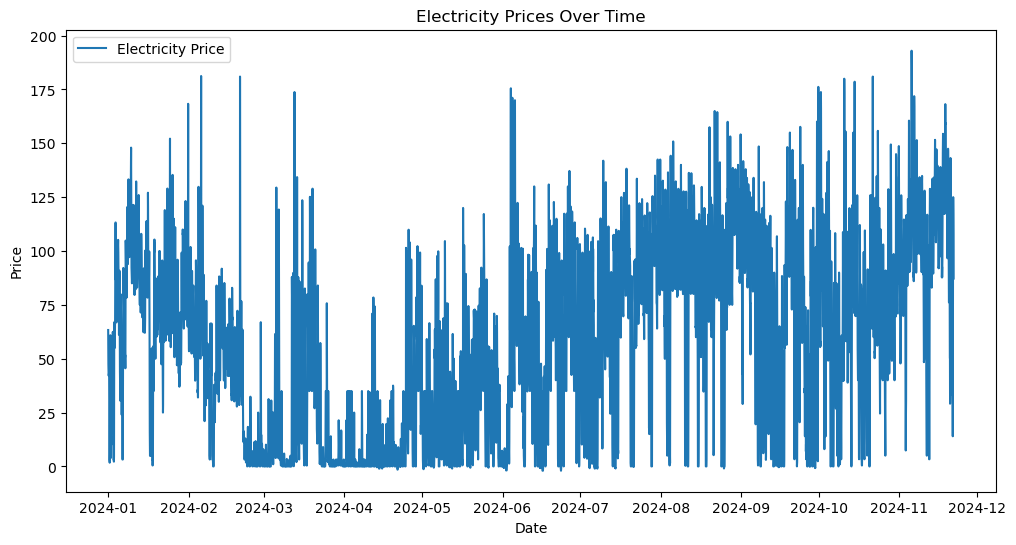

In [10]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(full_data['historical_spainPrice'], label='Electricity Price')
#plt.plot(full_data['WIND_D+1_DAILY_FORECAST'], label='WIND_D+1_DAILY_FORECAST')
#plt.plot(full_data['DEMAND_D+1_DAILY_FORECAST'], label='DEMAND_D+1_DAILY_FORECAST')
#plt.plot(full_data['PHOTOVOLTAIC_D+1_DAILY_FORECAST'], label='PHOTOVOLTAIC_D+1_DAILY_FORECAST')
#plt.plot(full_data['SOLAR_THERMAL_FORECAST'], label='SOLAR_THERMAL_FORECAST')
plt.title('Electricity Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
full_data.columns

Index(['historical_spainPrice', 'WIND_D+1_DAILY_FORECAST',
       'DEMAND_D+1_DAILY_FORECAST', 'PHOTOVOLTAIC_D+1_DAILY_FORECAST',
       'SOLAR_THERMAL_FORECAST'],
      dtype='object')

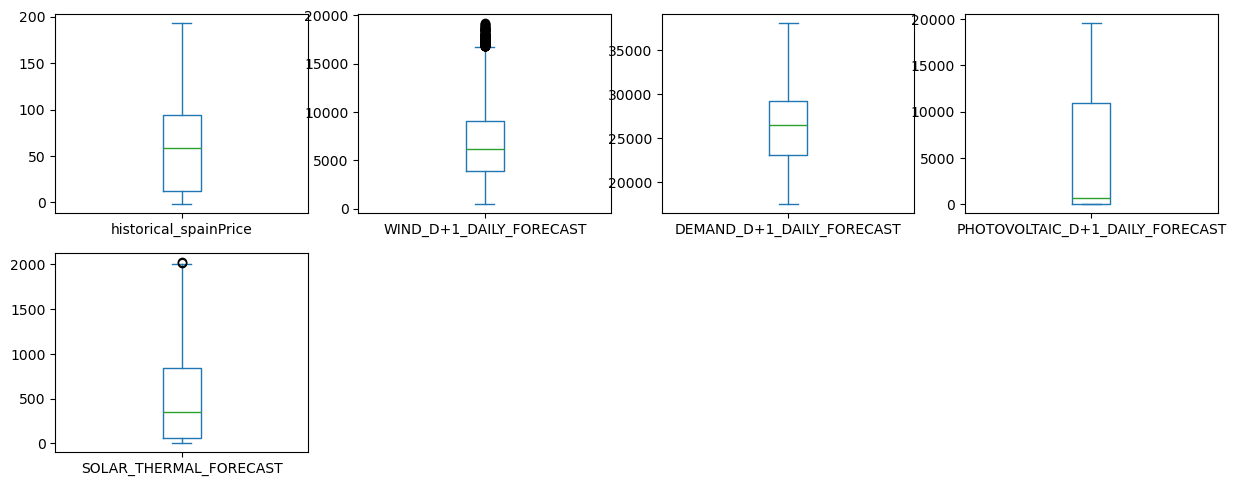

In [25]:
boxplot_attributes = full_data.plot(kind='box', subplots=True, layout=(5, 4), figsize=(15, 15),
                                 sharex=False, sharey=False, fontsize=10)

### Normalize the data and create the adequate format for the model

In [20]:
# Preprocess the data: Normalize datas
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(full_data)

In [21]:
# Create sequences
FORECAST_HORIZON = 24  # Predict the next 24 hours
SEQ_LENGTH = 30 * 24  # 30 days of hourly data (30 * 24)

def create_sequences(data, seq_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon):
        X.append(data[i:i + seq_length, :])
        y.append(data[i + seq_length:i + seq_length + forecast_horizon, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LENGTH, FORECAST_HORIZON)
X

array([[[3.35025641e-01, 2.26918395e-01, 2.01380270e-01, 0.00000000e+00,
         3.20884654e-03],
        [2.67128205e-01, 2.22817846e-01, 1.58005908e-01, 0.00000000e+00,
         0.00000000e+00],
        [2.53846154e-01, 2.15503065e-01, 8.72159520e-02, 0.00000000e+00,
         0.00000000e+00],
        ...,
        [4.97743590e-01, 1.10469214e-01, 7.66118160e-01, 0.00000000e+00,
         7.65680152e-02],
        [4.65128205e-01, 1.14511031e-01, 6.06919846e-01, 0.00000000e+00,
         3.50998445e-02],
        [4.14256410e-01, 1.17463640e-01, 4.59757528e-01, 0.00000000e+00,
         1.87964357e-02]],

       [[2.67128205e-01, 2.22817846e-01, 1.58005908e-01, 0.00000000e+00,
         0.00000000e+00],
        [2.53846154e-01, 2.15503065e-01, 8.72159520e-02, 0.00000000e+00,
         0.00000000e+00],
        [2.33333333e-01, 2.08588728e-01, 3.70862474e-02, 0.00000000e+00,
         4.93668699e-04],
        ...,
        [4.65128205e-01, 1.14511031e-01, 6.06919846e-01, 0.00000000e+00,
        

## Data spliting

In [22]:
from sklearn.model_selection import train_test_split

test_size = 0.3
random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state,
                                                    shuffle=True)
X_train.shape

(4956, 720, 5)

## Model creation and fit

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1])  # Prédiction finale
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/Users/lucaslevasseur/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 720, 64)        │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 720, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,008 (132.84 KB)

 Trainable params: 34,008 (132.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 254ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 247ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 250ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 8/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 9/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 10/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 246ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 11/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 12/40
155/155

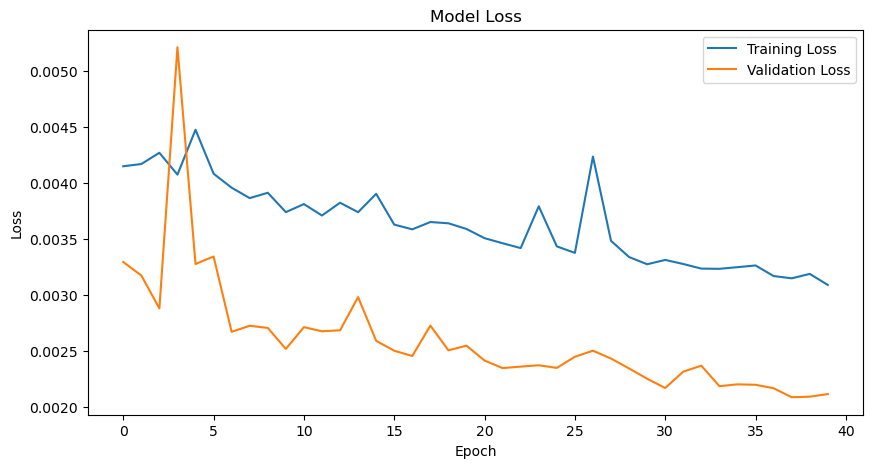

plot8


In [59]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=1)

print('plot7')

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print('plot8')

In [60]:
# Make predictions
predictions = model.predict(X_test) 

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


In [61]:
# Reversing the normalization
predictions_original = []
for pred in predictions:
    pred_reshaped = np.zeros((pred.shape[0], scaler.scale_.shape[0]))
    pred_reshaped[:, 0] = pred.flatten()
    
    pred_original = scaler.inverse_transform(pred_reshaped)[:, 0]
    
    predictions_original.append(pred_original)

predictions_original = np.array(predictions_original)


In [62]:
y_test_original = []
for y in y_test:
    y_reshaped = np.zeros((y.shape[0], scaler.scale_.shape[0]))
    y_reshaped[:, 0] = y.flatten()
    
    y_original = scaler.inverse_transform(y_reshaped)[:, 0]
    
    y_test_original.append(y_original)

y_test_original = np.array(y_test_original)

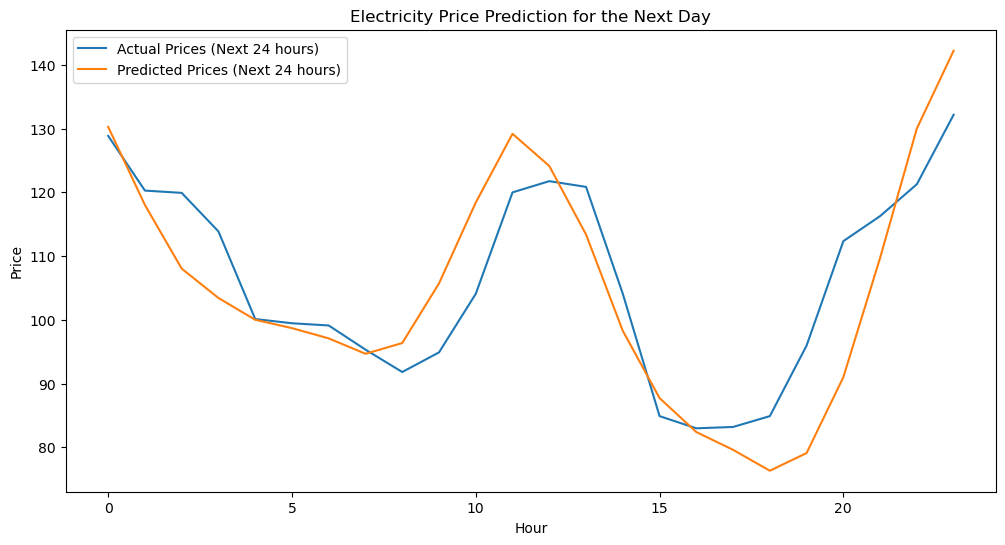

plot10


In [63]:
# Plot predictions vs. actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[0], label='Actual Prices (Next 24 hours)')
plt.plot(predictions_original[0], label='Predicted Prices (Next 24 hours)')
plt.title('Electricity Price Prediction for the Next Day')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.legend()
plt.show()
print('plot10')

### Metric values

In [69]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

r2 = r2_score(y_test_original, predictions_original)

rmse = mean_squared_error(y_test_original, predictions_original, squared=False)

MAE = mean_absolute_error(y_test_original, predictions_original)

MAPE = mean_absolute_percentage_error(y_test_original, predictions_original)

predictions_corrected = []
for pred in predictions_original:
    predictions_corrected.append(pred)
    for i in range(len(pred)):
        if pred[i] <= 0:
            predictions_corrected[-1][i] = 0.01
predictions_corrected = np.array(predictions_corrected)

y_corrected = []
for y_i in y_test_original:
    y_corrected.append(y_i)
    for i in range(len(y_i)):
        if y_i[i] <= 0:
            y_corrected[-1][i] = 0.01
y_corrected = np.array(y_corrected)

MAPE2 = mean_absolute_percentage_error(y_corrected, predictions_corrected)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {MAE:.4f}")
print(f"MAPE: {MAPE:.4f}")

R² Score: 0.9583
RMSE: 8.9079
MAE: 6.3873
MAPE: 31.1100
MAPE2: 31.1100


/Users/lucaslevasseur/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


576


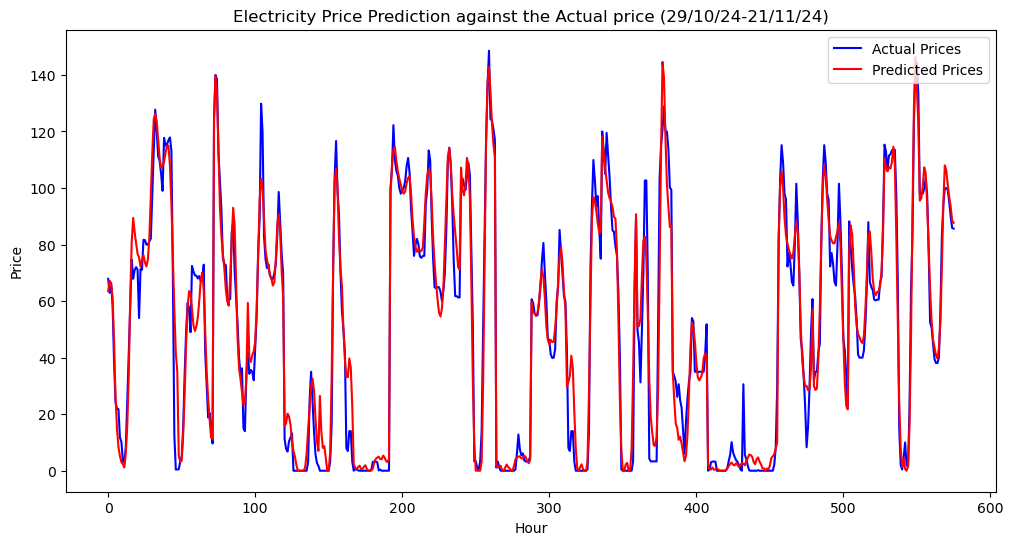

Plot complete


In [ ]:
# Print a example of prediction
hours_per_day = 1
begining_date = 25
ending_date = 1

days_actual = y_test_original[-begining_date * hours_per_day:-ending_date * hours_per_day].flatten()  # Les 5 derniers jours des données réelles
days_predicted = predictions_original[-begining_date * hours_per_day:-ending_date * hours_per_day].flatten()  # Les 5 derniers jours des données prédites
print(len(days_actual))

# Plot predictions vs. actual for the entire test set
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(days_actual, label='Actual Prices', color='blue')  # Flatten in case it's multi-dimensional
# Plot predicted values
plt.plot(days_predicted, label='Predicted Prices', color='red')  # Flatten in case it's multi-dimensional

# Adding title and labels
plt.title('Electricity Price Prediction against the Actual price (29/10/24-21/11/24)')
plt.xlabel('Hour')
plt.ylabel('Price')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

print('Plot complete')


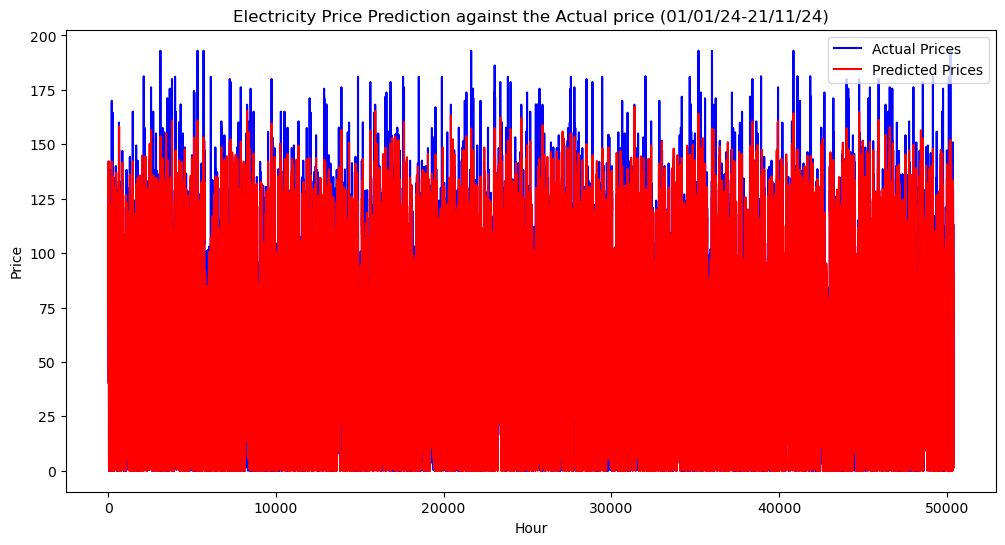

In [84]:
# Print all the prediction
hours_per_day = 24
begining_date = 0
ending_date = 1

days_actual = y_test_original[-begining_date * hours_per_day:-ending_date * hours_per_day].flatten()  # Les 5 derniers jours des données réelles
days_predicted = predictions_original[-begining_date * hours_per_day:-ending_date * hours_per_day].flatten()  # Les 5 derniers jours des données prédites

# Plot predictions vs. actual for the entire test set
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(days_actual, label='Actual Prices', color='blue')  # Flatten in case it's multi-dimensional
# Plot predicted values
plt.plot(days_predicted, label='Predicted Prices', color='red')  # Flatten in case it's multi-dimensional

# Adding title and labels
plt.title('Electricity Price Prediction against the Actual price (01/01/24-21/11/24)')
plt.xlabel('Hour')
plt.ylabel('Price')

# Adding a legend
plt.legend()

# Display the plot
plt.show()
